In [2]:
!pip install google-generativeai openai

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import datetime as dt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pointbiserialr
from sklearn.ensemble import IsolationForest
import os
import google.generativeai as genai
from google.colab import userdata
from openai import OpenAI

In [2]:
data = pd.read_csv('FinancialMarketData.xlsx - EWS.csv')

In [3]:
df = pd.DataFrame(data)
df

,Y,Data,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,0,1/11/2000,283.25,0.077,1388.0,157.2600,100.560,105.86,1.6460,25.77,...,116.4640,230.527,123.7620,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,0,1/18/2000,287.65,0.043,1405.0,165.0100,101.860,105.47,1.6380,28.85,...,117.2670,231.377,123.7620,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,0,1/25/2000,287.15,0.135,1368.0,167.2400,102.410,106.04,1.6500,28.28,...,117.9950,232.390,123.7620,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,0,2/1/2000,282.75,0.191,1311.0,166.8500,104.920,107.85,1.6110,28.22,...,120.5100,231.942,122.3280,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,1,2/8/2000,298.40,0.312,1277.0,165.4300,104.220,109.30,1.6110,28.02,...,118.7910,237.812,122.3280,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,3/23/2021,1727.96,0.339,2271.0,184.5022,92.336,108.72,1.3760,57.76,...,427.7972,1249.403,389.8500,3800.77,140.32,1199.57,1671.73,681.21,1695.96,110.83
1107,0,3/30/2021,1685.56,0.303,2103.0,184.8741,93.297,110.29,1.3719,60.55,...,428.6578,1242.264,385.8145,3835.96,142.76,1206.29,1635.57,693.38,1690.76,108.80
1108,0,4/6/2021,1743.28,0.440,2092.0,185.8393,92.335,109.88,1.3822,59.33,...,430.6649,1250.256,390.6819,3955.16,144.13,1194.62,1689.62,673.20,1689.48,111.92
1109,0,4/13/2021,1742.69,0.467,2140.0,188.1368,91.852,109.19,1.3737,60.18,...,430.4087,1252.563,390.3848,4027.05,144.23,1197.06,1680.82,680.23,1672.46,108.40


In [4]:
#Find correlations of features to Y
correlations=df.drop(columns = ['Data'])
print(correlations.corr())
correlations=correlations.drop("Y", axis=1).apply(lambda x: x.corr(df.Y))
correlations = correlations.sort_values(ascending=False)
correlations #Top ascending VIX GTIT2,10,30 EONIA

                  Y  XAU BGNL  ECSURPUS      BDIY       CRY       DXY  \
Y          1.000000 -0.011535 -0.090772 -0.083440 -0.074102  0.103227   
XAU BGNL  -0.011535  1.000000  0.114798 -0.315007  0.015316 -0.428891   
ECSURPUS  -0.090772  0.114798  1.000000 -0.102022 -0.139779  0.074835   
BDIY      -0.083440 -0.315007 -0.102022  1.000000  0.596182 -0.441793   
CRY       -0.074102  0.015316 -0.139779  0.596182  1.000000 -0.798564   
DXY        0.103227 -0.428891  0.074835 -0.441793 -0.798564  1.000000   
JPY       -0.151197 -0.576191 -0.070422  0.062822 -0.412364  0.650429   
GBP       -0.093201 -0.422084 -0.188233  0.756718  0.793954 -0.544966   
Cl1       -0.070141  0.515215 -0.016245  0.286396  0.785614 -0.816378   
VIX        0.598432 -0.075873 -0.094127 -0.045367 -0.190060  0.115712   
USGG30YR   0.019255 -0.868696 -0.015927  0.390852  0.256228  0.187296   
GT10      -0.004776 -0.893317 -0.016744  0.391498  0.178731  0.274784   
USGG2YR   -0.034909 -0.742875 -0.058576  0.324485  

,0
VIX,0.598432
GTITL2YR,0.304528
GTITL10YR,0.297573
GTITL30YR,0.295000
EONIA,0.180311
GTDEM30Y,0.141537
GTDEM10Y,0.139933
GTJPY10YR,0.133660
GTDEM2Y,0.130607
GTJPY30YR,0.114555


In [5]:
client = OpenAI(api_key = userdata.get('OPEN_AI_KEY'))

In [6]:
prompt = f"""You are an expert financial data analyst. You have a time series dataset of stock prices at certain dates, with 'Data' representing the date, and 'Y' as a binary target that represents whether an anomaly occured in the stock market on that date.
 Your goal is to develop a model that detects anomalies in the stock market based on this time series data. Each feature other than the 'Data' column represents a stock ticker. Let's go through the process step by step.

  Step 1. Your first step is to find what each stock ticker represents in the data
  Step 2. Your second step is to analyze the values of the stock tickers at each date and how the values differ than usual when the binary target('Y') is '1' (1 means anomaly occured on that date).
    This means you should look for outliers in the data such as sudden spikes in the prices of the stock tickers.
    Contextualize anomalous dates from 2000 to 2021 by matching them with dates of known black swan events, such as (but not limited to) the Dot Com Bubble, 2008 Financial Crisis and the COVID-19 pandemic
    In addition to the information from the dataset, you should consider the correlations of each stock ticker to the target column in your analysis. The list of correlations is given here:"{str(list(correlations))}
    These correlations can help you make a more accurate analysis of whether if a stock ticker is more suited for anomaly detection or not.
    Remember not to solely rely on the provided correlations as there may be other factors that can influence a stock ticker's reliability.

  Step 3. Your third step is to rank each of these stock tickers on reliability for anomaly detection. List out the top 15 most reliable and 15 least reliable stock tickers.

  Now, apply these steps in your analysis of the dataset. Do not just make suggestions or an outline, make sure to complete each step. Verify that the information in each step is correct.

  Do not give me hypothetical placeholder values anywhere, only use the tickers in the dataset
  """


user_prompt = f"This is the given dataset: {str(list(df))}"

response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "developer", "content": prompt},
        {"role": "user", "content": user_prompt}
    ]
)

# Print the  from the API
message = response.choices[0].message.content

In [7]:
print(response.choices[0].message.content)

Great, let's proceed with the analysis by following the outlined steps:

### Step 1: Identify Stock Tickers

The given dataset comprises a list of stock tickers and financial indicators, here is what each ticker likely represents:

1. **'XAU BGNL'** - Gold (XAU is the trading symbol for one troy ounce of gold) expressed in a specific index or contract, possibly Bloomberg Gold Total Return.
2. **'ECSURPUS'** - U.S. Economic Surprise Index, which measures the degree of economic data variation from the consensus forecast.
3. **'BDIY'** - Baltic Dry Index, tracks rates to ship raw materials.
4. **'CRY'** - Refers to the Commodity Research Bureau index, which tracks commodity prices.
5. **'DXY'** - U.S. Dollar Index measuring the dollar value relative to a basket of foreign currencies.
6. **'JPY'** - Japanese Yen currency value.
7. **'GBP'** - British Pound currency value.
8. **'Cl1'** - Front month light sweet crude oil futures contract price.
9. **'VIX'** - CBOE Volatility Index, often ca

In [5]:
features = df.drop(columns=['Y'])
features

,Data,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,1/11/2000,283.25,0.077,1388.0,157.2600,100.560,105.86,1.6460,25.77,22.50,...,116.4640,230.527,123.7620,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,1/18/2000,287.65,0.043,1405.0,165.0100,101.860,105.47,1.6380,28.85,21.50,...,117.2670,231.377,123.7620,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,1/25/2000,287.15,0.135,1368.0,167.2400,102.410,106.04,1.6500,28.28,23.02,...,117.9950,232.390,123.7620,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,2/1/2000,282.75,0.191,1311.0,166.8500,104.920,107.85,1.6110,28.22,23.45,...,120.5100,231.942,122.3280,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,2/8/2000,298.40,0.312,1277.0,165.4300,104.220,109.30,1.6110,28.02,21.25,...,118.7910,237.812,122.3280,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,3/23/2021,1727.96,0.339,2271.0,184.5022,92.336,108.72,1.3760,57.76,20.30,...,427.7972,1249.403,389.8500,3800.77,140.32,1199.57,1671.73,681.21,1695.96,110.83
1107,3/30/2021,1685.56,0.303,2103.0,184.8741,93.297,110.29,1.3719,60.55,19.61,...,428.6578,1242.264,385.8145,3835.96,142.76,1206.29,1635.57,693.38,1690.76,108.80
1108,4/6/2021,1743.28,0.440,2092.0,185.8393,92.335,109.88,1.3822,59.33,18.12,...,430.6649,1250.256,390.6819,3955.16,144.13,1194.62,1689.62,673.20,1689.48,111.92
1109,4/13/2021,1742.69,0.467,2140.0,188.1368,91.852,109.19,1.3737,60.18,16.65,...,430.4087,1252.563,390.3848,4027.05,144.23,1197.06,1680.82,680.23,1672.46,108.40


In [6]:
target = df['Y']
target

,Y
0,0
1,0
2,0
3,0
4,1
...,...
1106,0
1107,0
1108,0
1109,0


In [12]:
count = 0
for i in target:
    if i == 1:
        count += 1
print(str((count/len(target))*100),"%")

21.332133213321335 %


In [7]:
#Convert datetime of data['DATA']
features['Data'] = pd.to_datetime(df["Data"])

In [8]:
features

,Data,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,2000-01-11,283.25,0.077,1388.0,157.2600,100.560,105.86,1.6460,25.77,22.50,...,116.4640,230.527,123.7620,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,2000-01-18,287.65,0.043,1405.0,165.0100,101.860,105.47,1.6380,28.85,21.50,...,117.2670,231.377,123.7620,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,2000-01-25,287.15,0.135,1368.0,167.2400,102.410,106.04,1.6500,28.28,23.02,...,117.9950,232.390,123.7620,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,2000-02-01,282.75,0.191,1311.0,166.8500,104.920,107.85,1.6110,28.22,23.45,...,120.5100,231.942,122.3280,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,2000-02-08,298.40,0.312,1277.0,165.4300,104.220,109.30,1.6110,28.02,21.25,...,118.7910,237.812,122.3280,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,2021-03-23,1727.96,0.339,2271.0,184.5022,92.336,108.72,1.3760,57.76,20.30,...,427.7972,1249.403,389.8500,3800.77,140.32,1199.57,1671.73,681.21,1695.96,110.83
1107,2021-03-30,1685.56,0.303,2103.0,184.8741,93.297,110.29,1.3719,60.55,19.61,...,428.6578,1242.264,385.8145,3835.96,142.76,1206.29,1635.57,693.38,1690.76,108.80
1108,2021-04-06,1743.28,0.440,2092.0,185.8393,92.335,109.88,1.3822,59.33,18.12,...,430.6649,1250.256,390.6819,3955.16,144.13,1194.62,1689.62,673.20,1689.48,111.92
1109,2021-04-13,1742.69,0.467,2140.0,188.1368,91.852,109.19,1.3737,60.18,16.65,...,430.4087,1252.563,390.3848,4027.05,144.23,1197.06,1680.82,680.23,1672.46,108.40


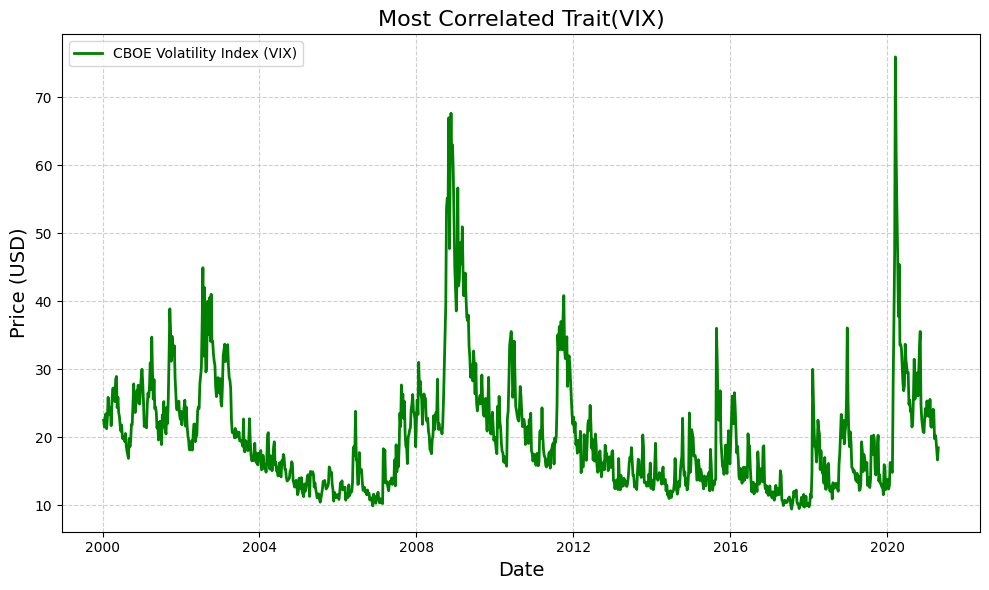

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(features['Data'], features['VIX'], label='CBOE Volatility Index (VIX)', color='green', linewidth=2)
plt.title('Most Correlated Trait(VIX)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

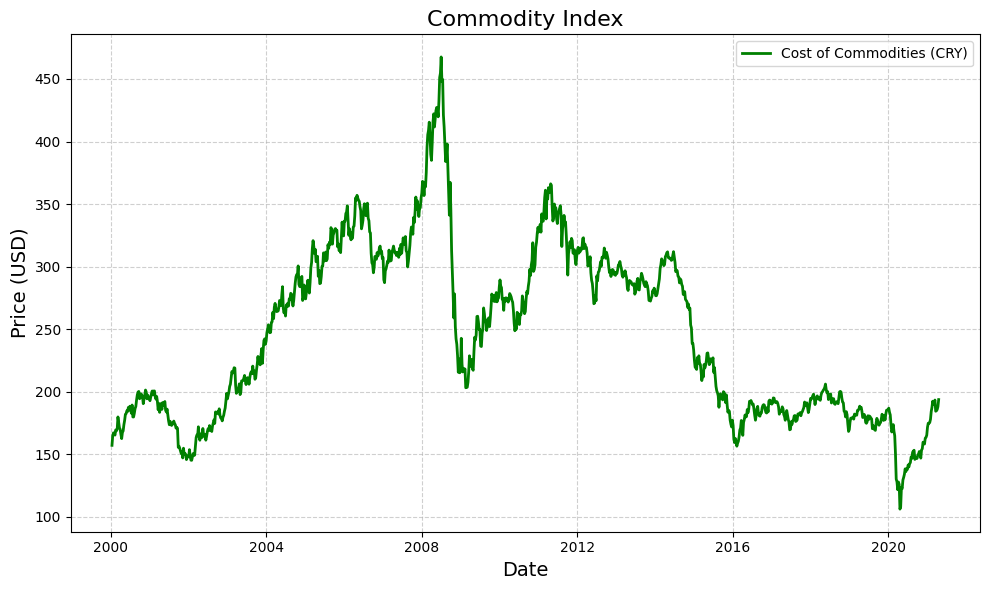

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(features['Data'], features['CRY'], label='Cost of Commodities (CRY)', color='green', linewidth=2)
plt.title('Commodity Index', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

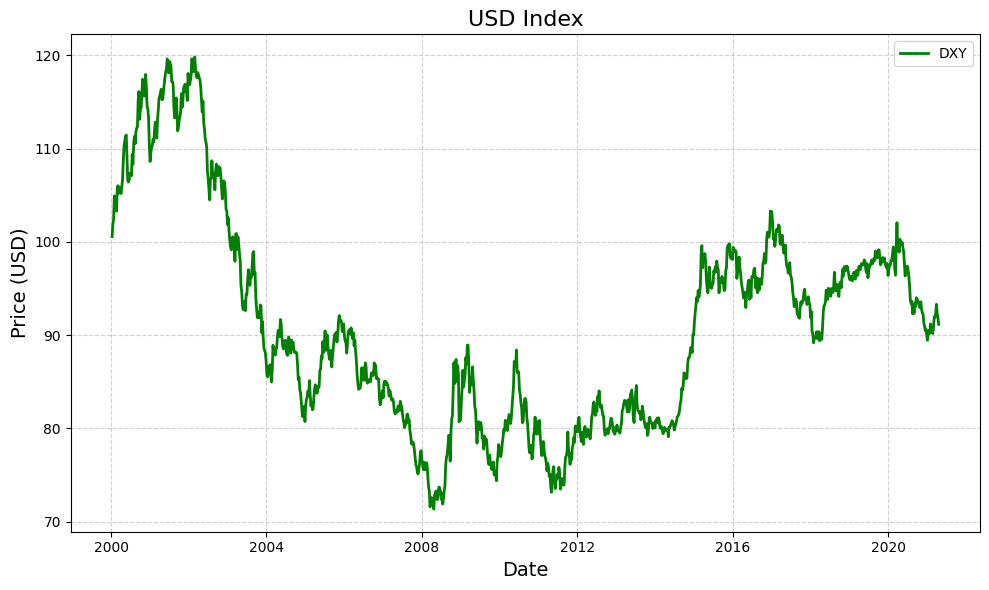

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(features['Data'], features['DXY'], label='DXY', color='green', linewidth=2)
plt.title('USD Index', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

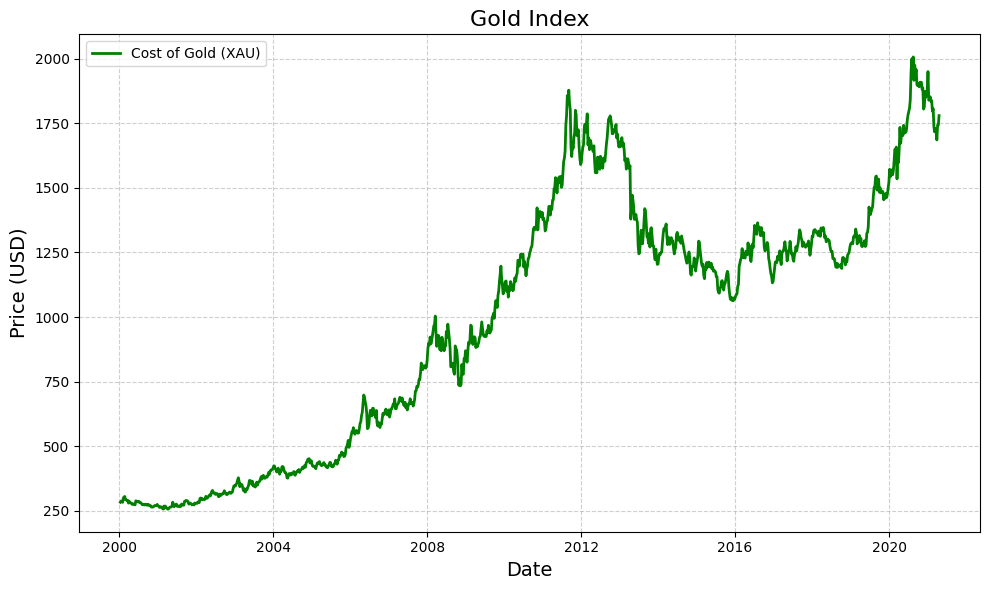

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(features['Data'], features['XAU BGNL'], label='Cost of Gold (XAU)', color='green', linewidth=2)
plt.title('Gold Index', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
correlation = features['XAU BGNL'].corr(features['DXY'])

print(f"The correlation between XAU BGNL and DXY is: {correlation:.2f}")

The correlation between XAU BGNL and DXY is: -0.43


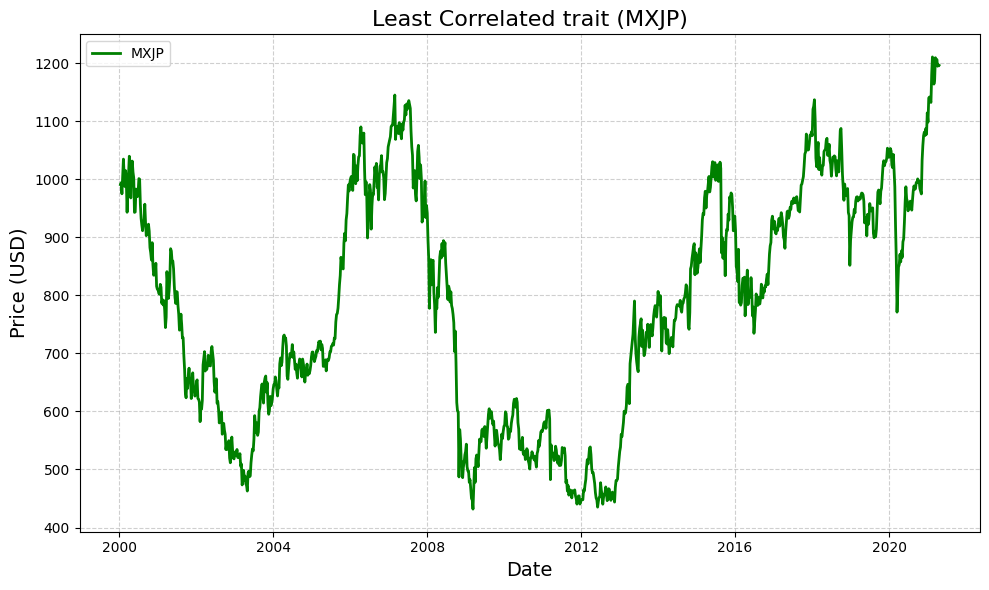

In [21]:
plt.figure(figsize=(10, 6))
#plt.plot(train_data['Data'], train_data['MXJP'], label='MXJP', color='red', linewidth=2)
plt.plot(features['Data'], features['MXJP'], label='MXJP', color='green', linewidth=2)
plt.title('Least Correlated trait (MXJP)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Simple LR

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

In [10]:
train_data = features.drop(columns=['Data'])

In [25]:
#Drop least correlated features
"""Based on hypothetical results:
Based on the provided correlations, stock tickers are ranked for their reliability in detecting anomalies. Here are the top 15 and least reliable 15:

**Top 15 Most Reliable Tickers (highest to lowest correlation with 'Y'):**
1. `XAU BGNL`: 0.5984
2. `ECSURPUS`: 0.3045
3. `BDIY`: 0.2976
4. `CRY`: 0.2950
5. `DXY`: 0.1803
6. `JPY`: 0.1415
7. `GBP`: 0.1399
8. `Cl1`: 0.1337
9. `VIX`: 0.1306
10. `USGG30YR`: 0.1146
11. `GT10`: 0.1123
12. `USGG2YR`: 0.1032
13. `USGG3M`: 0.1001
14. `US0001M`: 0.0998
15. `GTDEM30Y`: 0.0350

**15 Least Reliable Tickers (lowest to highest correlation with 'Y'):**
1. `MXCN`: -0.2794
2. `MXIN`: -0.2539
3. `MXRU`: -0.2098
4. `MXBR`: -0.1972
5. `GTJPY2YR`: -0.1939
6. `GTJPY10YR`: -0.1897
7. `GTJPY30YR`: -0.1889
8. `MXJP`: -0.1695
9. `MXEU`: -0.1566
10. `MXUS`: -0.1535
11. `GTGBP2Y`: -0.1512
12. `GTGBP20Y`: -0.1496
13. `GTGBP30Y`: -0.1488
14. `GTITL2YR`: -0.1436
15. `GTITL10YR`: -0.1049

The correlations indicate which stock tickers are more strongly associated with anomalies. However, further analysis and context consideration are needed for a comprehensive model for anomaly detection.
"""


"Based on hypothetical results:\nBased on the provided correlations, stock tickers are ranked for their reliability in detecting anomalies. Here are the top 15 and least reliable 15:\n\n**Top 15 Most Reliable Tickers (highest to lowest correlation with 'Y'):**\n1. `XAU BGNL`: 0.5984\n2. `ECSURPUS`: 0.3045\n3. `BDIY`: 0.2976\n4. `CRY`: 0.2950\n5. `DXY`: 0.1803\n6. `JPY`: 0.1415\n7. `GBP`: 0.1399\n8. `Cl1`: 0.1337\n9. `VIX`: 0.1306\n10. `USGG30YR`: 0.1146\n11. `GT10`: 0.1123\n12. `USGG2YR`: 0.1032\n13. `USGG3M`: 0.1001\n14. `US0001M`: 0.0998\n15. `GTDEM30Y`: 0.0350\n\n**15 Least Reliable Tickers (lowest to highest correlation with 'Y'):**\n1. `MXCN`: -0.2794\n2. `MXIN`: -0.2539\n3. `MXRU`: -0.2098\n4. `MXBR`: -0.1972\n5. `GTJPY2YR`: -0.1939\n6. `GTJPY10YR`: -0.1897\n7. `GTJPY30YR`: -0.1889\n8. `MXJP`: -0.1695\n9. `MXEU`: -0.1566\n10. `MXUS`: -0.1535\n11. `GTGBP2Y`: -0.1512\n12. `GTGBP20Y`: -0.1496\n13. `GTGBP30Y`: -0.1488\n14. `GTITL2YR`: -0.1436\n15. `GTITL10YR`: -0.1049\n\nThe correlat

In [11]:
train_data = train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10','CRY','Cl1','USGG30YR', 'XAU BGNL']]

In [12]:
train_data

,BDIY,DXY,JPY,VIX,GT10,CRY,Cl1,USGG30YR,XAU BGNL
0,1388.0,100.560,105.86,22.50,6.657,157.2600,25.77,6.6710,283.25
1,1405.0,101.860,105.47,21.50,6.748,165.0100,28.85,6.7470,287.65
2,1368.0,102.410,106.04,23.02,6.692,167.2400,28.28,6.6340,287.15
3,1311.0,104.920,107.85,23.45,6.619,166.8500,28.22,6.4230,282.75
4,1277.0,104.220,109.30,21.25,6.613,165.4300,28.02,6.2310,298.40
...,...,...,...,...,...,...,...,...,...
1106,2271.0,92.336,108.72,20.30,1.622,184.5022,57.76,2.3264,1727.96
1107,2103.0,93.297,110.29,19.61,1.706,184.8741,60.55,2.3687,1685.56
1108,2092.0,92.335,109.88,18.12,1.658,185.8393,59.33,2.3230,1743.28
1109,2140.0,91.852,109.19,16.65,1.616,188.1368,60.18,2.2939,1742.69


In [13]:
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
import shap

In [14]:
train_data, target

(        BDIY      DXY     JPY    VIX   GT10       CRY    Cl1  USGG30YR  \
 0     1388.0  100.560  105.86  22.50  6.657  157.2600  25.77    6.6710   
 1     1405.0  101.860  105.47  21.50  6.748  165.0100  28.85    6.7470   
 2     1368.0  102.410  106.04  23.02  6.692  167.2400  28.28    6.6340   
 3     1311.0  104.920  107.85  23.45  6.619  166.8500  28.22    6.4230   
 4     1277.0  104.220  109.30  21.25  6.613  165.4300  28.02    6.2310   
 ...      ...      ...     ...    ...    ...       ...    ...       ...   
 1106  2271.0   92.336  108.72  20.30  1.622  184.5022  57.76    2.3264   
 1107  2103.0   93.297  110.29  19.61  1.706  184.8741  60.55    2.3687   
 1108  2092.0   92.335  109.88  18.12  1.658  185.8393  59.33    2.3230   
 1109  2140.0   91.852  109.19  16.65  1.616  188.1368  60.18    2.2939   
 1110  2432.0   91.147  108.09  18.46  1.565  193.8035  62.50    2.2619   
 
       XAU BGNL  
 0       283.25  
 1       287.65  
 2       287.15  
 3       282.75  
 4      

# Finding top Features

Test to find most important features from Logistic Regression, XGBoost, Isolation Forest

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target, test_size=0.2, random_state=42)

In [19]:
SMOTE = SMOTE(random_state=42)
X_train, y_train = SMOTE.fit_resample(X_train, y_train)#Smote makes it worse

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [17]:
lr_model = LogisticRegression()

In [18]:
def evaluate_and_save_model(model, X_train, X_test, y_train, y_test, filename):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model.__class__.__name__} Accuracy: {accuracy:.4f}")

    print(f"\nClassification Report:\n{classification_report(y_test,y_pred)}")
    print("------")

    with open(filename, "wb") as file:
      pickle.dump(model, file)

      print(f"Model saved as: {filename}")

In [19]:
evaluate_and_save_model(lr_model, X_train, X_test, y_train, y_test, "lr_model.pkl")

LogisticRegression Accuracy: 0.8700

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       177
           1       0.74      0.57      0.64        46

    accuracy                           0.87       223
   macro avg       0.82      0.76      0.78       223
weighted avg       0.86      0.87      0.86       223

------
Model saved as: lr_model.pkl


In [20]:
model_fi = permutation_importance(lr_model, X_train, y_train)
model_fi['importances_mean']

array([0.00337838, 0.09324324, 0.01644144, 0.17117117, 0.01801802,
       0.05337838, 0.01644144, 0.04346847, 0.00067568])

In [21]:
feature_names = train_data.columns
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model_fi['importances_mean']
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

    Feature  Importance
3       VIX    0.171171
1       DXY    0.093243
5       CRY    0.053378
7  USGG30YR    0.043468
4      GT10    0.018018
6       Cl1    0.016441
2       JPY    0.016441
0      BDIY    0.003378
8  XAU BGNL    0.000676


In [22]:
train_data.columns #If Thhe above outputs very good features, get them

Index(['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'USGG30YR',
       'XAU BGNL'],
      dtype='object')

Isolation Forest

In [23]:
iso_model = IsolationForest(n_estimators=50, max_samples='auto', contamination=0.21, max_features=1.0)
iso_model.fit(train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'USGG30YR',
       'XAU BGNL']])


IsolationForest(contamination=0.21, n_estimators=50)

In [24]:
#Default training data for testing
train_data = train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'USGG30YR',
       'XAU BGNL']]

In [25]:
train_data['scores']=iso_model.decision_function(train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'USGG30YR',
       'XAU BGNL']])
train_data['anomaly']=iso_model.predict(train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'USGG30YR',
       'XAU BGNL']])

In [26]:
train_data['anomaly'] = train_data['anomaly'].replace({-1: 1, 1: 0})

In [27]:
print("Percentage of outliers in data: {:.2f}%".format(len(train_data[train_data['anomaly'] == 1]) / len(train_data) * 100))

Percentage of outliers in data: 21.06%


In [28]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
print(classification_report(target, train_data['anomaly']))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       874
           1       0.50      0.49      0.49       237

    accuracy                           0.78      1111
   macro avg       0.68      0.68      0.68      1111
weighted avg       0.78      0.78      0.78      1111



In [ ]:
exp = shap.TreeExplainer(iso_model) #Explainer
shap_values = exp.shap_values(train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'USGG30YR',
       'XAU BGNL']])

In [ ]:
shap.summary_plot(shap_values,train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'USGG30YR',
       'XAU BGNL']], max_display=train_data.shape[1])

# **Feature Engineering and Applying Methods**


In [186]:
df = pd.read_csv('FinancialMarketData.xlsx - EWS.csv', parse_dates=['Data'])

In [187]:
features = df.drop(columns=['Y'])
features

,Data,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,2000-01-11,283.25,0.077,1388.0,157.2600,100.560,105.86,1.6460,25.77,22.50,...,116.4640,230.527,123.7620,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,2000-01-18,287.65,0.043,1405.0,165.0100,101.860,105.47,1.6380,28.85,21.50,...,117.2670,231.377,123.7620,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,2000-01-25,287.15,0.135,1368.0,167.2400,102.410,106.04,1.6500,28.28,23.02,...,117.9950,232.390,123.7620,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,2000-02-01,282.75,0.191,1311.0,166.8500,104.920,107.85,1.6110,28.22,23.45,...,120.5100,231.942,122.3280,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,2000-02-08,298.40,0.312,1277.0,165.4300,104.220,109.30,1.6110,28.02,21.25,...,118.7910,237.812,122.3280,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,2021-03-23,1727.96,0.339,2271.0,184.5022,92.336,108.72,1.3760,57.76,20.30,...,427.7972,1249.403,389.8500,3800.77,140.32,1199.57,1671.73,681.21,1695.96,110.83
1107,2021-03-30,1685.56,0.303,2103.0,184.8741,93.297,110.29,1.3719,60.55,19.61,...,428.6578,1242.264,385.8145,3835.96,142.76,1206.29,1635.57,693.38,1690.76,108.80
1108,2021-04-06,1743.28,0.440,2092.0,185.8393,92.335,109.88,1.3822,59.33,18.12,...,430.6649,1250.256,390.6819,3955.16,144.13,1194.62,1689.62,673.20,1689.48,111.92
1109,2021-04-13,1742.69,0.467,2140.0,188.1368,91.852,109.19,1.3737,60.18,16.65,...,430.4087,1252.563,390.3848,4027.05,144.23,1197.06,1680.82,680.23,1672.46,108.40


In [173]:
features['Month'] = features['Data'].dt.month
features['Year'] = features['Data'].dt.year

In [188]:
features.drop(columns=['Data'], inplace=True)

In [189]:
train_data = features[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'USGG30YR',
       'XAU BGNL']]

In [190]:
target = df[['Y']]

In [191]:
train_data

,BDIY,DXY,JPY,VIX,GT10,CRY,Cl1,USGG30YR,XAU BGNL
0,1388.0,100.560,105.86,22.50,6.657,157.2600,25.77,6.6710,283.25
1,1405.0,101.860,105.47,21.50,6.748,165.0100,28.85,6.7470,287.65
2,1368.0,102.410,106.04,23.02,6.692,167.2400,28.28,6.6340,287.15
3,1311.0,104.920,107.85,23.45,6.619,166.8500,28.22,6.4230,282.75
4,1277.0,104.220,109.30,21.25,6.613,165.4300,28.02,6.2310,298.40
...,...,...,...,...,...,...,...,...,...
1106,2271.0,92.336,108.72,20.30,1.622,184.5022,57.76,2.3264,1727.96
1107,2103.0,93.297,110.29,19.61,1.706,184.8741,60.55,2.3687,1685.56
1108,2092.0,92.335,109.88,18.12,1.658,185.8393,59.33,2.3230,1743.28
1109,2140.0,91.852,109.19,16.65,1.616,188.1368,60.18,2.2939,1742.69


In [192]:
train_data['Gold_USD_Ratio'] = train_data['XAU BGNL'] / df['DXY']

<ipython-input-192-4f3ade4dd755>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Gold_USD_Ratio'] = train_data['XAU BGNL'] / df['DXY']


In [193]:
train_data['JPY_to_USD'] = train_data['JPY'] / df['DXY']

<ipython-input-193-3d4404db7bd0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['JPY_to_USD'] = train_data['JPY'] / df['DXY']


In [194]:
train_data

,BDIY,DXY,JPY,VIX,GT10,CRY,Cl1,USGG30YR,XAU BGNL,Gold_USD_Ratio,JPY_to_USD
0,1388.0,100.560,105.86,22.50,6.657,157.2600,25.77,6.6710,283.25,2.816726,1.052705
1,1405.0,101.860,105.47,21.50,6.748,165.0100,28.85,6.7470,287.65,2.823974,1.035441
2,1368.0,102.410,106.04,23.02,6.692,167.2400,28.28,6.6340,287.15,2.803925,1.035446
3,1311.0,104.920,107.85,23.45,6.619,166.8500,28.22,6.4230,282.75,2.694910,1.027926
4,1277.0,104.220,109.30,21.25,6.613,165.4300,28.02,6.2310,298.40,2.863174,1.048743
...,...,...,...,...,...,...,...,...,...,...,...
1106,2271.0,92.336,108.72,20.30,1.622,184.5022,57.76,2.3264,1727.96,18.713828,1.177439
1107,2103.0,93.297,110.29,19.61,1.706,184.8741,60.55,2.3687,1685.56,18.066604,1.182139
1108,2092.0,92.335,109.88,18.12,1.658,185.8393,59.33,2.3230,1743.28,18.879948,1.190015
1109,2140.0,91.852,109.19,16.65,1.616,188.1368,60.18,2.2939,1742.69,18.972804,1.188760


In [195]:
def apply_rolling_average(df):
    excluded_columns = {'Month', 'Year', 'Day'}
    for col in df.columns:
        if col not in excluded_columns:
            df[f"{col}_rolling_avg"] = df[col].rolling(window=20, min_periods=1).mean()

    return df


In [196]:
apply_rolling_average(train_data)

<ipython-input-195-743882db38bc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_rolling_avg"] = df[col].rolling(window=20, min_periods=1).mean()
<ipython-input-195-743882db38bc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_rolling_avg"] = df[col].rolling(window=20, min_periods=1).mean()
<ipython-input-195-743882db38bc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,BDIY,DXY,JPY,VIX,GT10,CRY,Cl1,USGG30YR,XAU BGNL,Gold_USD_Ratio,...,DXY_rolling_avg,JPY_rolling_avg,VIX_rolling_avg,GT10_rolling_avg,CRY_rolling_avg,Cl1_rolling_avg,USGG30YR_rolling_avg,XAU BGNL_rolling_avg,Gold_USD_Ratio_rolling_avg,JPY_to_USD_rolling_avg
0,1388.0,100.560,105.86,22.50,6.657,157.2600,25.77,6.6710,283.25,2.816726,...,100.56000,105.8600,22.5000,6.65700,157.260000,25.770000,6.671000,283.250000,2.816726,1.052705
1,1405.0,101.860,105.47,21.50,6.748,165.0100,28.85,6.7470,287.65,2.823974,...,101.21000,105.6650,22.0000,6.70250,161.135000,27.310000,6.709000,285.450000,2.820350,1.044073
2,1368.0,102.410,106.04,23.02,6.692,167.2400,28.28,6.6340,287.15,2.803925,...,101.61000,105.7900,22.3400,6.69900,163.170000,27.633333,6.684000,286.016667,2.814875,1.041197
3,1311.0,104.920,107.85,23.45,6.619,166.8500,28.22,6.4230,282.75,2.694910,...,102.43750,106.3050,22.6175,6.67900,164.090000,27.780000,6.618750,285.200000,2.784884,1.037879
4,1277.0,104.220,109.30,21.25,6.613,165.4300,28.02,6.2310,298.40,2.863174,...,102.79400,106.9040,22.3440,6.66580,164.358000,27.828000,6.541200,287.840000,2.800542,1.040052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,2271.0,92.336,108.72,20.30,1.622,184.5022,57.76,2.3264,1727.96,18.713828,...,91.01225,105.0805,22.7855,1.13035,173.784010,52.519000,1.883975,1826.501000,20.073477,1.154581
1107,2103.0,93.297,110.29,19.61,1.706,184.8741,60.55,2.3687,1685.56,18.066604,...,91.03965,105.3300,22.5260,1.16760,175.350070,53.478500,1.915335,1816.685000,19.962306,1.156922
1108,2092.0,92.335,109.88,18.12,1.658,185.8393,59.33,2.3230,1743.28,18.879948,...,91.03560,105.6125,22.2965,1.20755,176.915915,54.373500,1.951190,1809.502000,19.885408,1.160031
1109,2140.0,91.852,109.19,16.65,1.616,188.1368,60.18,2.2939,1742.69,18.972804,...,91.01690,105.8405,22.0470,1.24430,178.333190,55.137000,1.985625,1806.384500,19.855452,1.162744


In [182]:
train_data

,BDIY,DXY,JPY,VIX,GT10,CRY,Cl1,USGG30YR,XAU BGNL,JPY_to_USD,BDIY_rolling_avg,DXY_rolling_avg,JPY_rolling_avg,VIX_rolling_avg,GT10_rolling_avg,CRY_rolling_avg,Cl1_rolling_avg,USGG30YR_rolling_avg,XAU BGNL_rolling_avg,JPY_to_USD_rolling_avg
0,1388.0,100.560,105.86,22.50,6.657,157.2600,25.77,6.6710,283.25,1.052705,1388.00,100.56000,105.8600,22.5000,6.65700,157.260000,25.770000,6.671000,283.250000,1.052705
1,1405.0,101.860,105.47,21.50,6.748,165.0100,28.85,6.7470,287.65,1.035441,1396.50,101.21000,105.6650,22.0000,6.70250,161.135000,27.310000,6.709000,285.450000,1.044073
2,1368.0,102.410,106.04,23.02,6.692,167.2400,28.28,6.6340,287.15,1.035446,1387.00,101.61000,105.7900,22.3400,6.69900,163.170000,27.633333,6.684000,286.016667,1.041197
3,1311.0,104.920,107.85,23.45,6.619,166.8500,28.22,6.4230,282.75,1.027926,1368.00,102.43750,106.3050,22.6175,6.67900,164.090000,27.780000,6.618750,285.200000,1.037879
4,1277.0,104.220,109.30,21.25,6.613,165.4300,28.02,6.2310,298.40,1.048743,1349.80,102.79400,106.9040,22.3440,6.66580,164.358000,27.828000,6.541200,287.840000,1.040052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,2271.0,92.336,108.72,20.30,1.622,184.5022,57.76,2.3264,1727.96,1.177439,1512.65,91.01225,105.0805,22.7855,1.13035,173.784010,52.519000,1.883975,1826.501000,1.154581
1107,2103.0,93.297,110.29,19.61,1.706,184.8741,60.55,2.3687,1685.56,1.182139,1557.80,91.03965,105.3300,22.5260,1.16760,175.350070,53.478500,1.915335,1816.685000,1.156922
1108,2092.0,92.335,109.88,18.12,1.658,185.8393,59.33,2.3230,1743.28,1.190015,1606.80,91.03560,105.6125,22.2965,1.20755,176.915915,54.373500,1.951190,1809.502000,1.160031
1109,2140.0,91.852,109.19,16.65,1.616,188.1368,60.18,2.2939,1742.69,1.188760,1654.90,91.01690,105.8405,22.0470,1.24430,178.333190,55.137000,1.985625,1806.384500,1.162744


Rolling Average


In [146]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target, test_size=0.2, random_state=42, shuffle=False)

In [43]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)#somehow better without smote

In [147]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [148]:
lr_model = LogisticRegression()

In [149]:
def evaluate_and_save_model(model, X_train, X_test, y_train, y_test, filename):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model.__class__.__name__} Accuracy: {accuracy:.4f}")

    print(f"\nClassification Report:\n{classification_report(y_test,y_pred)}")
    print("------")

    with open(filename, "wb") as file:
      pickle.dump(model, file)

      print(f"Model saved as: {filename}")

In [150]:
evaluate_and_save_model(lr_model, X_train, X_test, y_train, y_test, "lr_model_features.pkl")

LogisticRegression Accuracy: 0.8610

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       194
           1       0.47      0.62      0.54        29

    accuracy                           0.86       223
   macro avg       0.71      0.76      0.73       223
weighted avg       0.88      0.86      0.87       223

------
Model saved as: lr_model_features.pkl


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [151]:
model_fi = permutation_importance(lr_model, X_train, y_train)
model_fi['importances_mean']

array([ 0.00540541,  0.04842342,  0.04391892,  0.17184685,  0.00337838,
        0.00225225,  0.01126126,  0.07094595,  0.01013514,  0.02297297,
        0.0045045 ,  0.0795045 ,  0.01846847,  0.0045045 ,  0.0795045 ,
        0.02117117,  0.025     , -0.00022523,  0.04346847,  0.04887387])

In [152]:
feature_names = train_data.columns
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model_fi['importances_mean']
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

                       Feature  Importance
3                          VIX    0.171847
11             DXY_rolling_avg    0.079505
14            GT10_rolling_avg    0.079505
7                     USGG30YR    0.070946
19  Gold_USD_Ratio_rolling_avg    0.048874
1                          DXY    0.048423
2                          JPY    0.043919
18        XAU BGNL_rolling_avg    0.043468
16             Cl1_rolling_avg    0.025000
9               Gold_USD_Ratio    0.022973
15             CRY_rolling_avg    0.021171
12             JPY_rolling_avg    0.018468
6                          Cl1    0.011261
8                     XAU BGNL    0.010135
0                         BDIY    0.005405
13             VIX_rolling_avg    0.004505
10            BDIY_rolling_avg    0.004505
4                         GT10    0.003378
5                          CRY    0.002252
17        USGG30YR_rolling_avg   -0.000225


In [153]:
train_data.columns

Index(['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'USGG30YR',
       'XAU BGNL', 'Gold_USD_Ratio', 'BDIY_rolling_avg', 'DXY_rolling_avg',
       'JPY_rolling_avg', 'VIX_rolling_avg', 'GT10_rolling_avg',
       'CRY_rolling_avg', 'Cl1_rolling_avg', 'USGG30YR_rolling_avg',
       'XAU BGNL_rolling_avg', 'Gold_USD_Ratio_rolling_avg'],
      dtype='object')

In [154]:
iso_data = train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'USGG30YR',
       'XAU BGNL', 'BDIY_rolling_avg', 'DXY_rolling_avg',
       'JPY_rolling_avg', 'VIX_rolling_avg', 'GT10_rolling_avg', 'USGG30YR_rolling_avg',
       'XAU BGNL_rolling_avg', 'Gold_USD_Ratio_rolling_avg']]

In [155]:
iso_model = IsolationForest(n_estimators=50, max_samples='auto', contamination=0.2, max_features=1.0)
iso_model.fit(iso_data)

IsolationForest(contamination=0.2, n_estimators=50)

In [156]:
iso_data['scores']=iso_model.decision_function(train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'USGG30YR',
       'XAU BGNL', 'BDIY_rolling_avg', 'DXY_rolling_avg',
       'JPY_rolling_avg', 'VIX_rolling_avg', 'GT10_rolling_avg',
   'USGG30YR_rolling_avg',
       'XAU BGNL_rolling_avg', 'Gold_USD_Ratio_rolling_avg']])
iso_data['anomaly']=iso_model.predict(train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'USGG30YR',
       'XAU BGNL', 'BDIY_rolling_avg', 'DXY_rolling_avg',
       'JPY_rolling_avg', 'VIX_rolling_avg', 'GT10_rolling_avg', 'USGG30YR_rolling_avg',
       'XAU BGNL_rolling_avg', 'Gold_USD_Ratio_rolling_avg']])

<ipython-input-156-daad09467010>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_data['scores']=iso_model.decision_function(train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'USGG30YR',
<ipython-input-156-daad09467010>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_data['anomaly']=iso_model.predict(train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'USGG30YR',


In [157]:
iso_data['anomaly'] = iso_data['anomaly'].replace({-1: 1, 1: 0})

<ipython-input-157-3ba8693ed88c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_data['anomaly'] = iso_data['anomaly'].replace({-1: 1, 1: 0})


In [158]:
print("Percentage of outliers in data: {:.2f}%".format(len(iso_data[iso_data['anomaly'] == 1]) / len(iso_data) * 100))

Percentage of outliers in data: 19.98%


In [159]:
print(classification_report(target, iso_data['anomaly']))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       874
           1       0.47      0.44      0.46       237

    accuracy                           0.78      1111
   macro avg       0.66      0.65      0.66      1111
weighted avg       0.77      0.78      0.77      1111



In [160]:
exp = shap.TreeExplainer(iso_model) #Explainer
shap_values = exp.shap_values(iso_data)

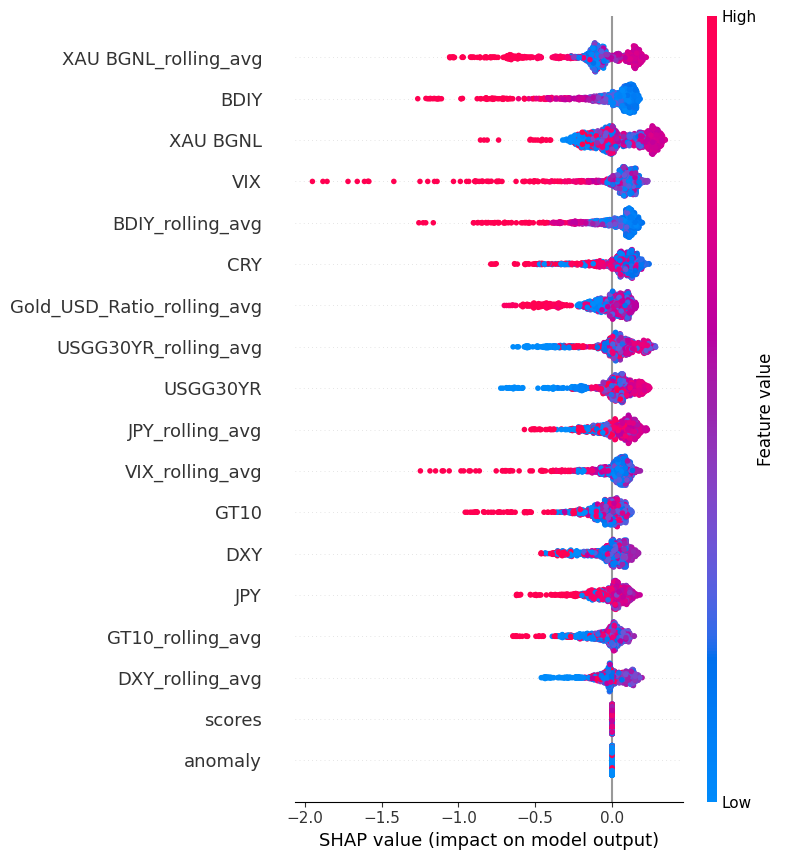

In [161]:
shap.summary_plot(shap_values, iso_data, max_display=iso_data.shape[1])

In [162]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 0.7, 0.8],
    'contamination': [0.2, 0.21, 0.25],
    'max_features': [1.0, 0.8],
}
iso_forest = IsolationForest(random_state=42)

In [163]:
grid_search = GridSearchCV(iso_forest, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=IsolationForest(random_state=42),
             param_grid={'contamination': [0.2, 0.21, 0.25],
                         'max_features': [1.0, 0.8],
                         'max_samples': ['auto', 0.7, 0.8],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [164]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'contamination': 0.2, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 50}
Best score: 0.0


In [165]:
import xgboost as xgb

In [197]:
train_data

,BDIY,DXY,JPY,VIX,GT10,CRY,Cl1,USGG30YR,XAU BGNL,Gold_USD_Ratio,...,DXY_rolling_avg,JPY_rolling_avg,VIX_rolling_avg,GT10_rolling_avg,CRY_rolling_avg,Cl1_rolling_avg,USGG30YR_rolling_avg,XAU BGNL_rolling_avg,Gold_USD_Ratio_rolling_avg,JPY_to_USD_rolling_avg
0,1388.0,100.560,105.86,22.50,6.657,157.2600,25.77,6.6710,283.25,2.816726,...,100.56000,105.8600,22.5000,6.65700,157.260000,25.770000,6.671000,283.250000,2.816726,1.052705
1,1405.0,101.860,105.47,21.50,6.748,165.0100,28.85,6.7470,287.65,2.823974,...,101.21000,105.6650,22.0000,6.70250,161.135000,27.310000,6.709000,285.450000,2.820350,1.044073
2,1368.0,102.410,106.04,23.02,6.692,167.2400,28.28,6.6340,287.15,2.803925,...,101.61000,105.7900,22.3400,6.69900,163.170000,27.633333,6.684000,286.016667,2.814875,1.041197
3,1311.0,104.920,107.85,23.45,6.619,166.8500,28.22,6.4230,282.75,2.694910,...,102.43750,106.3050,22.6175,6.67900,164.090000,27.780000,6.618750,285.200000,2.784884,1.037879
4,1277.0,104.220,109.30,21.25,6.613,165.4300,28.02,6.2310,298.40,2.863174,...,102.79400,106.9040,22.3440,6.66580,164.358000,27.828000,6.541200,287.840000,2.800542,1.040052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,2271.0,92.336,108.72,20.30,1.622,184.5022,57.76,2.3264,1727.96,18.713828,...,91.01225,105.0805,22.7855,1.13035,173.784010,52.519000,1.883975,1826.501000,20.073477,1.154581
1107,2103.0,93.297,110.29,19.61,1.706,184.8741,60.55,2.3687,1685.56,18.066604,...,91.03965,105.3300,22.5260,1.16760,175.350070,53.478500,1.915335,1816.685000,19.962306,1.156922
1108,2092.0,92.335,109.88,18.12,1.658,185.8393,59.33,2.3230,1743.28,18.879948,...,91.03560,105.6125,22.2965,1.20755,176.915915,54.373500,1.951190,1809.502000,19.885408,1.160031
1109,2140.0,91.852,109.19,16.65,1.616,188.1368,60.18,2.2939,1742.69,18.972804,...,91.01690,105.8405,22.0470,1.24430,178.333190,55.137000,1.985625,1806.384500,19.855452,1.162744


In [198]:
train_data.columns

Index(['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'USGG30YR',
       'XAU BGNL', 'Gold_USD_Ratio', 'JPY_to_USD', 'BDIY_rolling_avg',
       'DXY_rolling_avg', 'JPY_rolling_avg', 'VIX_rolling_avg',
       'GT10_rolling_avg', 'CRY_rolling_avg', 'Cl1_rolling_avg',
       'USGG30YR_rolling_avg', 'XAU BGNL_rolling_avg',
       'Gold_USD_Ratio_rolling_avg', 'JPY_to_USD_rolling_avg'],
      dtype='object')

In [211]:
from imblearn.under_sampling import RandomUnderSampler

In [256]:
xgb_data = train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'USGG30YR',
       'XAU BGNL', 'Gold_USD_Ratio', 'JPY_to_USD', 'BDIY_rolling_avg', 'DXY_rolling_avg',
       'JPY_rolling_avg', 'VIX_rolling_avg',  'JPY_to_USD_rolling_avg',
       'CRY_rolling_avg','USGG30YR_rolling_avg']]

In [258]:
X_train, X_test, y_train, y_test = train_test_split(xgb_data, target, test_size=0.2, random_state=42, shuffle=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       194
           1       0.86      0.62      0.72        29

    accuracy                           0.94       223
   macro avg       0.90      0.80      0.84       223
weighted avg       0.93      0.94      0.93       223



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:56:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [259]:
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])]
importance = model.get_booster().get_score(importance_type='weight')
mapped_importance = {feature_names[int(k[1:])]: v for k, v in importance.items()}
importance_df = pd.DataFrame(mapped_importance.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                   Feature  Importance
3                      VIX       137.0
12         VIX_rolling_avg       103.0
8               JPY_to_USD        87.0
2                      JPY        83.0
9         BDIY_rolling_avg        74.0
0                     BDIY        72.0
13  JPY_to_USD_rolling_avg        72.0
6                 XAU BGNL        68.0
7           Gold_USD_Ratio        65.0
14         CRY_rolling_avg        64.0
4                     GT10        63.0
15    USGG30YR_rolling_avg        62.0
5                 USGG30YR        61.0
1                      DXY        52.0
11         JPY_rolling_avg        52.0
10         DXY_rolling_avg        47.0


In [264]:
evaluate_and_save_model(model, X_train, X_test, y_train, y_test, "xgb_model.pkl")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:58:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier Accuracy: 0.9372

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       194
           1       0.86      0.62      0.72        29

    accuracy                           0.94       223
   macro avg       0.90      0.80      0.84       223
weighted avg       0.93      0.94      0.93       223

------
Model saved as: xgb_model.pkl


In [266]:
from sklearn.ensemble import RandomForestClassifier

In [408]:
features.columns

Index(['XAU BGNL', 'ECSURPUS', 'BDIY', 'CRY', 'DXY', 'JPY', 'GBP', 'Cl1',
       'VIX', 'USGG30YR', 'GT10', 'USGG2YR', 'USGG3M', 'US0001M', 'GTDEM30Y',
       'GTDEM10Y', 'GTDEM2Y', 'EONIA', 'GTITL30YR', 'GTITL10YR', 'GTITL2YR',
       'GTJPY30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTGBP30Y', 'GTGBP20Y', 'GTGBP2Y',
       'LUMSTRUU', 'LMBITR', 'LUACTRUU', 'LF98TRUU', 'LG30TRUU', 'LP01TREU',
       'EMUSTRUU', 'LF94TRUU', 'MXUS', 'MXEU', 'MXJP', 'MXBR', 'MXRU', 'MXIN',
       'MXCN'],
      dtype='object')

In [479]:
test_data = features

In [480]:
def apply_rolling_average(df):
    excluded_columns = {'Month', 'Year', 'Day'}
    for col in df.columns:
        if col not in excluded_columns:
            df[f"{col}_rolling_avg"] = df[col].rolling(window=20, min_periods=1).mean()

    return df

In [481]:
apply_rolling_average(test_data)

,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,USGG30YR,...,LP01TREU_rolling_avg,EMUSTRUU_rolling_avg,LF94TRUU_rolling_avg,MXUS_rolling_avg,MXEU_rolling_avg,MXJP_rolling_avg,MXBR_rolling_avg,MXRU_rolling_avg,MXIN_rolling_avg,MXCN_rolling_avg
0,283.25,0.077,1388.0,157.2600,100.560,105.86,1.6460,25.77,22.50,6.6710,...,116.464000,230.527000,123.762000,1416.1200,127.7500,990.590000,856.760000,224.330000,217.340000,34.300000
1,287.65,0.043,1405.0,165.0100,101.860,105.47,1.6380,28.85,21.50,6.7470,...,116.865500,230.952000,123.762000,1422.4550,128.6250,992.285000,890.990000,229.350000,222.210000,33.520000
2,287.15,0.135,1368.0,167.2400,102.410,106.04,1.6500,28.28,23.02,6.6340,...,117.242000,231.431333,123.762000,1410.2800,127.9100,986.466667,889.636667,225.173333,225.806667,33.166667
3,282.75,0.191,1311.0,166.8500,104.920,107.85,1.6110,28.22,23.45,6.4230,...,118.059000,231.559000,123.403500,1404.0375,128.2300,991.630000,877.877500,219.352500,228.725000,32.697500
4,298.40,0.312,1277.0,165.4300,104.220,109.30,1.6110,28.02,21.25,6.2310,...,118.205400,232.809600,123.188400,1405.6200,129.5180,1000.220000,891.332000,219.082000,234.584000,32.422000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,1727.96,0.339,2271.0,184.5022,92.336,108.72,1.3760,57.76,20.30,2.3264,...,421.923730,1269.336200,392.517355,3687.4940,134.1040,1128.861500,1757.476500,670.637500,1614.663500,113.178500
1107,1685.56,0.303,2103.0,184.8741,93.297,110.29,1.3719,60.55,19.61,2.3687,...,422.830305,1268.680350,392.758960,3707.9395,134.8655,1137.548500,1758.748000,675.801000,1627.102500,113.324000
1108,1743.28,0.440,2092.0,185.8393,92.335,109.88,1.3822,59.33,18.12,2.3230,...,423.724420,1268.079400,393.052050,3730.9045,135.6230,1144.383500,1761.117500,679.376500,1637.938000,113.626000
1109,1742.69,0.467,2140.0,188.1368,91.852,109.19,1.3737,60.18,16.65,2.2939,...,424.435020,1267.389600,393.262820,3755.6670,136.3210,1150.485000,1761.531500,682.616500,1647.420500,113.620500


In [432]:
train_data.columns

Index(['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'USGG30YR',
       'XAU BGNL', 'Gold_USD_Ratio', 'JPY_to_USD', 'BDIY_rolling_avg',
       'DXY_rolling_avg', 'JPY_rolling_avg', 'VIX_rolling_avg',
       'GT10_rolling_avg', 'CRY_rolling_avg', 'Cl1_rolling_avg',
       'USGG30YR_rolling_avg', 'XAU BGNL_rolling_avg',
       'Gold_USD_Ratio_rolling_avg', 'JPY_to_USD_rolling_avg'],
      dtype='object')

In [512]:
rf_data = train_data[['GT10_rolling_avg', 'VIX', 'VIX_rolling_avg',  'JPY_to_USD_rolling_avg','Gold_USD_Ratio_rolling_avg', 'Gold_USD_Ratio', 'DXY','DXY_rolling_avg' ]]

In [513]:
X_train, X_test, y_train, y_test = train_test_split(rf_data, target, test_size=0.2, random_state=42, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [514]:
evaluate_and_save_model(model, X_train, X_test, y_train, y_test, "rf_model.pkl")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier Accuracy: 0.9013

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       194
           1       0.64      0.55      0.59        29

    accuracy                           0.90       223
   macro avg       0.79      0.75      0.77       223
weighted avg       0.90      0.90      0.90       223

------
Model saved as: rf_model.pkl


In [515]:
feature_importances = model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])]
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
1,VIX,0.271265
2,VIX_rolling_avg,0.156724
3,JPY_to_USD_rolling_avg,0.118858
5,Gold_USD_Ratio,0.097793
4,Gold_USD_Ratio_rolling_avg,0.096866
7,DXY_rolling_avg,0.096317
0,GT10_rolling_avg,0.084547
6,DXY,0.077630


## Milestone 2